In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/atomic-hack/1400.xlsx
/kaggle/input/atomic-hack/35000.xlsx


In [13]:
!pip install simpletransformers -q
# !pip install rdkit -q

In [3]:
import transformers
from transformers import AutoTokenizer, AutoModel
# from simpletransformers.classification import ClassificationModel
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, Sampler
from torch.optim import lr_scheduler

import logging
logging.basicConfig(level=logging.INFO)
transformers_logger = logging.getLogger("transformers")
transformers_logger.setLevel(logging.WARNING)

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

import warnings
warnings.filterwarnings('ignore')

from tqdm import tqdm

import matplotlib.pyplot as plt
import seaborn as sns

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [19]:
data_1 = pd.read_excel('/kaggle/input/atomic-hack/1400.xlsx', sheet_name=1)
data_2 = pd.read_excel('/kaggle/input/atomic-hack/35000.xlsx')

# data_1 = data_1[['IC50, mmg/ml', 'SMILES']]
# data_2 = data_2[['IC50', 'SMILES']]

data_1.rename({'SMILES': 'text', 'IC50, mmg/ml': 'target'}, axis=1, inplace=True)
data_2.rename({'SMILES': 'text', 'IC50': 'target'}, axis=1, inplace=True)

In [5]:
data = pd.concat([data_1, data_2])
data = data.drop_duplicates()

data = data.loc[data['target'] <= data['target'].quantile(.97)]

data_smiles = data.copy()

# токенизация и получение представление с помощью fingerprints

In [6]:
from rdkit import Chem
from rdkit.Chem import AllChem

In [7]:
ic50_values = [float(item) for item in data_smiles['target'].values]
smiles = [item for item in data['text'].values]

In [ ]:
def smiles_to_morgan(smiles, radius=2, nBits=2048):
    mol = Chem.MolFromSmiles(smiles)
    if mol is not None:
        return np.array(AllChem.GetMorganFingerprintAsBitVect(mol, radius, nBits=nBits))
    else:
        return np.zeros(nBits)

In [ ]:
fingerprints = [smiles_to_morgan(s) for s in tqdm(smiles)]

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(fingerprints, ic50_values, test_size=0.3)

# Линейная регрессия

In [8]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error, r2_score

In [ ]:
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)
predictions_linear = linear_model.predict(X_test)

In [ ]:
print(f'MAE: {mean_absolute_error(y_test, predictions_linear)}')
print(f'MAPE: {mean_absolute_percentage_error(y_test, predictions_linear)}')
print(f'MSE: {mean_squared_error(y_test, predictions_linear)}')
print(f'RMSE: {np.sqrt(mean_squared_error(y_test, predictions_linear))}')
print(f'R2: {r2_score(y_test, predictions_linear)}')

# catboost

In [ ]:
from catboost import CatBoostRegressor

In [ ]:
model_catboost = CatBoostRegressor(random_state=42, verbose=100)
model_catboost.fit(X_train, y_train)
predictions_catboost = model_catboost.predict(X_test)

In [ ]:
print(f'MAE: {mean_absolute_error(y_test, predictions_catboost)}')
print(f'MAPE: {mean_absolute_percentage_error(y_test, predictions_catboost)}')
print(f'MSE: {mean_squared_error(y_test, predictions_catboost)}')
print(f'RMSE: {np.sqrt(mean_squared_error(y_test, predictions_catboost))}')
print(f'R2: {r2_score(y_test, predictions_catboost)}')

# simple Network

In [ ]:
class SimpleNNDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y
        
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return torch.tensor(self.X[idx]), torch.tensor(self.y[idx], dtype=torch.float32)
    
simple_train_dataset = SimpleNNDataset(X_train, y_train)
simple_test_dataset = SimpleNNDataset(X_test, y_test)

simple_train_dataloader = DataLoader(simple_train_dataset, num_workers=2, shuffle=True, batch_size=32)
simple_test_dataloader = DataLoader(simple_test_dataset, num_workers=2, shuffle=False, batch_size=32)

In [ ]:
class SimpleNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(SimpleNN, self).__init__()
        
        self.layer_1 = nn.Sequential(
            nn.Linear(input_dim, hidden_dim * 2),
            nn.BatchNorm1d(hidden_dim * 2),
            nn.ReLU(),
        )
        
        self.layer_2 = nn.Sequential(
            nn.Linear(hidden_dim * 2, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU(),
        )
        
        self.fc = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, batch):
        
        batch = self.layer_1(batch)
        batch = self.layer_2(batch)
        out = self.fc(batch)
        return out

In [ ]:
input_dim = 2048
hidden_dim = 256
output_dim = 1



device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

simple_model = SimpleNN(input_dim, hidden_dim, output_dim)
simple_model = simple_model.to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.AdamW(simple_model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.7)

In [ ]:
def compute_rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

def compute_mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def train(epoch, model):
    model.train()
    running_loss = 0.0
    preds = []
    true_values = []
    
    for batch_idx, (data, target) in enumerate(simple_train_dataloader):
        data, target = data.to(device), target.to(device)
        
        optimizer.zero_grad()
        outputs = model(data)
        
        loss = criterion(outputs, target)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        preds.extend(outputs.detach().cpu().numpy())
        true_values.extend(target.detach().cpu().numpy())
    
    scheduler.step()
    
    train_loss = running_loss / len(simple_train_dataloader)
    rmse = compute_rmse(true_values, preds)
    r2 = r2_score(true_values, preds)
    mae = mean_absolute_error(true_values, preds)
    mape = compute_mape(np.array(true_values), np.array(preds))
    
    print(f"Epoch {epoch+1}, Train Loss: {train_loss:.3f}, RMSE: {rmse:.3f}, R2: {r2:.3f}, MAE: {mae:.3f}, MAPE: {mape:.3f}%")
    return train_loss, rmse, r2, mae, mape

def validate(epoch, model):
    model.eval()
    running_loss = 0.0
    preds = []
    true_values = []
    
    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(simple_test_dataloader):
            data, target = data.to(device), target.to(device)

            outputs = model(data)
            
            loss = criterion(outputs, target)
            running_loss += loss.item()
            
            preds.extend(outputs.detach().cpu().numpy())
            true_values.extend(target.detach().cpu().numpy())
    
    val_loss = running_loss / len(simple_test_dataloader)
    rmse = compute_rmse(true_values, preds)
    r2 = r2_score(true_values, preds)
    mae = mean_absolute_error(true_values, preds)
    mape = compute_mape(np.array(true_values), np.array(preds))
    
    print(f"Epoch {epoch+1}, Val Loss: {val_loss:.3f}, RMSE: {rmse:.3f}, R2: {r2:.3f}, MAE: {mae:.3f}, MAPE: {mape:.3f}%")
    return val_loss, rmse, r2, mae, mape

In [ ]:
for epoch in tqdm(range(50)):
    train(epoch, simple_model)
    validate(epoch, simple_model)

# чуть более лучшая

In [ ]:
class EmbsNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(EmbsNN, self).__init__()
        
        self.embedding = nn.Embedding(embedding_dim, input_dim)
        
        self.layer_1 = nn.Sequential(
            nn.Linear(input_dim, hidden_dim * 2),
            nn.BatchNorm1d(hidden_dim * 2),
            nn.ReLU(),
        )
        
        self.layer_2 = nn.Sequential(
            nn.Linear(hidden_dim * 2, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU(),
        )
        
        self.fc = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, batch):
        batch = self.embedding(batch)
        batch = self.layer_1(batch)
        batch = self.layer_2(batch)
        out = self.fc(batch)
        return out

In [ ]:
embedding_dim = 2048
input_dim = 1024
hidden_dim = 256
output_dim = 1

device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
print(device)

emb_model = EmbsNN(input_dim, hidden_dim, output_dim)
emb_model = emb_model.to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.AdamW(emb_model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.7)

In [ ]:
for epoch in range(30):
    train(epoch, emb_model)
    validate(epoch, emb_model)

# LSTM model

In [ ]:
class LSTMNN(nn.Module):
    def __init__(self, embedding_dim, input_dim, hidden_dim, output_dim, dropout_rate):
        super(LSTMNN, self).__init__()
        
        self.lstm = nn.Sequential(
            nn.Embedding(embedding_dim, input_dim),
            nn.LSTM(input_dim, hidden_dim, batch_first=True, bidirectional=True, num_layers=1),
        )
        
        self.fc = nn.Linear(hidden_dim * 2, 1)
        
    def forward(self, batch):
#         print(batch.shape)
        batch, _ = self.lstm(batch)
        batch = batch[:, -1, :]
#         print(batch.shape)
        out = self.fc(batch)
#         print(out.shape)
        return out

In [ ]:
embedding_dim = 2048
input_dim = 1024
hidden_dim = 256
output_dim = 1
dropout_rate=.2

device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
print(device)

lstm_model = LSTMNN(embedding_dim, input_dim, hidden_dim, output_dim, dropout_rate)
lstm_model = lstm_model.to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.AdamW(lstm_model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.7)

In [ ]:
def compute_rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

def compute_mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def train(epoch, model):
    model.train()
    running_loss = 0.0
    preds = []
    true_values = []
    
    for batch_idx, (data, target) in enumerate(simple_train_dataloader):
        data, target = data.to(device), target.to(device)
#         print(data.shape)
#         print(target.shape)
        optimizer.zero_grad()
        outputs = model(data)
        
        loss = criterion(outputs, target)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        preds.extend(outputs.detach().cpu().numpy())
        true_values.extend(target.detach().cpu().numpy())
    
    scheduler.step()
    
    train_loss = running_loss / len(simple_train_dataloader)
    rmse = compute_rmse(true_values, preds)
    r2 = r2_score(true_values, preds)
    mae = mean_absolute_error(true_values, preds)
    mape = compute_mape(np.array(true_values), np.array(preds))
    
    print(f"Epoch {epoch+1}, Train Loss: {train_loss:.3f}, RMSE: {rmse:.3f}, R2: {r2:.3f}, MAE: {mae:.3f}, MAPE: {mape:.3f}%")
    return train_loss, rmse, r2, mae, mape

def validate(epoch, model):
    model.eval()
    running_loss = 0.0
    preds = []
    true_values = []
    
    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(simple_test_dataloader):
            data, target = data.to(device), target.to(device)

            outputs = model(data)
            
            loss = criterion(outputs, target)
            running_loss += loss.item()
            
            preds.extend(outputs.detach().cpu().numpy())
            true_values.extend(target.detach().cpu().numpy())
    
    val_loss = running_loss / len(simple_test_dataloader)
    rmse = compute_rmse(true_values, preds)
    r2 = r2_score(true_values, preds)
    mae = mean_absolute_error(true_values, preds)
    mape = compute_mape(np.array(true_values), np.array(preds))
    
    print(f"Epoch {epoch+1}, Val Loss: {val_loss:.3f}, RMSE: {rmse:.3f}, R2: {r2:.3f}, MAE: {mae:.3f}, MAPE: {mape:.3f}%")
    return val_loss, rmse, r2, mae, mape

In [ ]:
for epoch in range(30):
    train(epoch, lstm_model)
    validate(epoch, lstm_model)

# chemberta sentencetransformers
## DeepChem/ChemBERTa-77M-MTR

In [14]:
from simpletransformers.classification import ClassificationModel

In [8]:
data_smiles.rename({'target': 'labels'}, axis=1, inplace=True)
X_train, X_test = train_test_split(data_smiles, random_state=42, shuffle=42, test_size=0.3)

In [27]:
model_77m_mtr = ClassificationModel(
    "roberta",
    "DeepChem/ChemBERTa-77M-MTR",
    num_labels=1,
    args={
        "num_train_epochs": 3,
        "regression": True,
        "use_multiprocessing": False,
        "use_multiprocessing_for_evaluation": False,
    },
    use_cuda=True,
)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at DeepChem/ChemBERTa-77M-MTR and are newly initialized: ['classifier.out_proj.weight', 'classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [28]:
model_77m_mtr.train_model(
    train_df=X_train,
    args={
            "num_train_epochs": 3,
            "overwrite_output_dir": True
         },
)

Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

Running Epoch 0 of 3:   0%|          | 0/3090 [00:00<?, ?it/s]

Running Epoch 1 of 3:   0%|          | 0/3090 [00:00<?, ?it/s]

Running Epoch 2 of 3:   0%|          | 0/3090 [00:00<?, ?it/s]

(9270, 9.26075379835942)

In [29]:
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def root_mean_squared_error(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

In [30]:
metrics = {
    "mape": mean_absolute_percentage_error,
    "mae": mean_absolute_error,
    "rmse": root_mean_squared_error,
    "mse": mean_squared_error,
    "r2": r2_score
}

In [31]:
result, model_outputs, wrong_predictions = model_77m_mtr.eval_model(
    X_test, **metrics
)
print(result)
print(model_outputs.max(), model_outputs.min())

Running Evaluation:   0%|          | 0/1324 [00:00<?, ?it/s]

{'mape': 5785.145091900501, 'mae': 2.1319941671509364, 'rmse': 2.9120337440985, 'mse': 8.479940526768328, 'r2': 0.1388981097285814, 'eval_loss': 8.479940507819826}
7.171875 -0.2064208984375


  0%|          | 0/1324 [00:00<?, ?it/s]

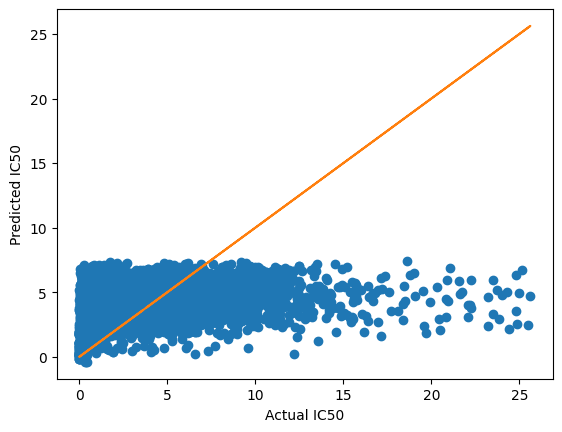

In [24]:
predictions = model.predict(X_test["text"].tolist())[0]

# plot the predictions
plt.scatter(X_test["labels"].tolist(), predictions, color="C0")
plt.plot(X_test["labels"], X_test["labels"], color="C1")
plt.xlabel("Actual IC50")
plt.ylabel("Predicted IC50")
plt.show()

# other model
## seyonec/ChemBERTa_zinc250k_v2_40k

In [35]:
model_zinc = ClassificationModel(
    "roberta",
    "seyonec/ChemBERTa_zinc250k_v2_40k",
    num_labels=1,
    args={
        "num_train_epochs": 3,
        "regression": True,
        "use_multiprocessing": False,
        "use_multiprocessing_for_evaluation": False,
    },
    use_cuda=True,
)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at seyonec/ChemBERTa_zinc250k_v2_40k and are newly initialized: ['classifier.out_proj.weight', 'classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [36]:
model_zinc.train_model(
    train_df=X_train,
    args={
            "num_train_epochs": 3,
            "overwrite_output_dir": True
         },
)

Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

Running Epoch 0 of 3:   0%|          | 0/3090 [00:00<?, ?it/s]

Running Epoch 1 of 3:   0%|          | 0/3090 [00:00<?, ?it/s]

Running Epoch 2 of 3:   0%|          | 0/3090 [00:00<?, ?it/s]

(9270, 8.792885838526159)

In [37]:
result, model_outputs, wrong_predictions = model_zinc.eval_model(
    X_test, **metrics
)
print(result)
print(model_outputs.max(), model_outputs.min())

Running Evaluation:   0%|          | 0/1324 [00:00<?, ?it/s]

{'mape': 5235.282204566107, 'mae': 2.1155537744990998, 'rmse': 2.9009738233952165, 'mse': 8.415649124024261, 'r2': 0.14542662820773344, 'eval_loss': 8.41564912011346}
7.90234375 -0.006130218505859375


# GNN

In [39]:
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"

In [43]:
data_1 = pd.read_excel('/kaggle/input/atomic-hack/1400.xlsx', sheet_name=1)
data_2 = pd.read_excel('/kaggle/input/atomic-hack/35000.xlsx')

# data_1 = data_1[['IC50, mmg/ml', 'SMILES']]
# data_2 = data_2[['IC50', 'SMILES']]

data_1.rename({'SMILES': 'text', 'IC50, mmg/ml': 'target'}, axis=1, inplace=True)
data_2.rename({'SMILES': 'text', 'IC50': 'target'}, axis=1, inplace=True)

In [63]:
from rdkit import Chem
from torch_geometric.data import Data

import torch.nn.functional as F
from torch_geometric.nn import MessagePassing, GCNConv, global_mean_pool
from torch_geometric.data import DataLoader

In [57]:
def smiles_to_graph(smiles):
    mol = Chem.MolFromSmiles(smiles)
    num_atoms = mol.GetNumAtoms()

    # Получаем свойства атомов и связей
    atom_features = [atom.GetAtomicNum() for atom in mol.GetAtoms()]
    bond_types = [bond.GetBondTypeAsDouble() for bond in mol.GetBonds()]
    edge_indices = [(bond.GetBeginAtomIdx(), bond.GetEndAtomIdx()) for bond in mol.GetBonds()]

    x = torch.tensor(atom_features, dtype=torch.float).view(num_atoms, -1)
    edge_index = torch.tensor(edge_indices, dtype=torch.long).t().contiguous()
    edge_attr = torch.tensor(bond_types, dtype=torch.float).view(-1, 1)

    return Data(x=x, edge_index=edge_index, edge_attr=edge_attr)

In [59]:
graphs = [smiles_to_graph(smiles) for smiles in tqdm(data_2["text"])]

  0%|          | 0/36377 [00:00<?, ?it/s][07:16:00] Conflicting single bond directions around double bond at index 55.
[07:16:00]   BondStereo set to STEREONONE and single bond directions set to NONE.
 98%|█████████▊| 35815/36377 [01:21<00:01, 407.02it/s][07:17:22] Conflicting single bond directions around double bond at index 7.
[07:17:22]   BondStereo set to STEREONONE and single bond directions set to NONE.
100%|██████████| 36377/36377 [01:23<00:00, 436.88it/s]


In [62]:
class MPNN(torch.nn.Module):
    def __init__(self):
        super(MPNN, self).__init__()
        self.conv1 = GCNConv(1, 64)
        self.conv2 = GCNConv(64, 128)
        self.fc = torch.nn.Linear(128, 1)

    def forward(self, data):
        x, edge_index, edge_attr = data.x, data.edge_index, data.edge_attr

        x = F.relu(self.conv1(x, edge_index))
        x = F.relu(self.conv2(x, edge_index))
        x = global_mean_pool(x, data.batch)
        x = self.fc(x)

        return x

In [65]:
targets = torch.tensor(data_2['target'].values, dtype=torch.float).view(-1, 1)

In [67]:
dataset = list(zip(graphs, targets))
train_size = int(0.7 * len(dataset))
train_dataset = dataset[:train_size]
test_dataset = dataset[train_size:]

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [69]:
device = 'cuda:1' if torch.cuda.is_available() else 'cpu'

In [74]:
mpnn = MPNN()
mpnn = mpnn.to(device)
optimizer = torch.optim.Adam(mpnn.parameters(), lr=1e-3)
criterion = torch.nn.MSELoss()

def train_mpnn():
    mpnn.train()
    loss_all = 0
    for data, target in train_loader:
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = mpnn(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        loss_all += loss.item() * data.num_graphs
    return loss_all / len(train_dataset)

for epoch in range(100):
    train_loss = train_mpnn()
    print(f"Epoch: {epoch+1}, Loss: {train_loss:.4f}")


Epoch: 1, Loss: 2.3852
Epoch: 2, Loss: 2.3226
Epoch: 3, Loss: 2.3228
Epoch: 4, Loss: 2.3184
Epoch: 5, Loss: 2.3177
Epoch: 6, Loss: 2.3179
Epoch: 7, Loss: 2.3163
Epoch: 8, Loss: 2.3154
Epoch: 9, Loss: 2.3127
Epoch: 10, Loss: 2.3145
Epoch: 11, Loss: 2.3124
Epoch: 12, Loss: 2.3110
Epoch: 13, Loss: 2.3071
Epoch: 14, Loss: 2.3089
Epoch: 15, Loss: 2.3077
Epoch: 16, Loss: 2.3080
Epoch: 17, Loss: 2.3039
Epoch: 18, Loss: 2.3053
Epoch: 19, Loss: 2.3059
Epoch: 20, Loss: 2.3060
Epoch: 21, Loss: 2.3060
Epoch: 22, Loss: 2.3065
Epoch: 23, Loss: 2.3057
Epoch: 24, Loss: 2.3065
Epoch: 25, Loss: 2.3032
Epoch: 26, Loss: 2.3052
Epoch: 27, Loss: 2.3032
Epoch: 28, Loss: 2.3016
Epoch: 29, Loss: 2.3026
Epoch: 30, Loss: 2.3017
Epoch: 31, Loss: 2.3015
Epoch: 32, Loss: 2.3008
Epoch: 33, Loss: 2.2996
Epoch: 34, Loss: 2.3000
Epoch: 35, Loss: 2.2981
Epoch: 36, Loss: 2.2980
Epoch: 37, Loss: 2.2986
Epoch: 38, Loss: 2.2976
Epoch: 39, Loss: 2.2989
Epoch: 40, Loss: 2.2965
Epoch: 41, Loss: 2.2952
Epoch: 42, Loss: 2.2971
E

In [75]:
def test(loader):
    mpnn.eval()
    predictions = []
    with torch.no_grad():
        for data, target in loader:
            data, target = data.to(device), target.to(device)
            output = mpnn(data)
            predictions.extend(output.tolist())
    return predictions

test_predictions = test(test_loader)

# chemberta + catboost

In [20]:
data_2 = data_2[['text', 'target']]

In [21]:
data_2 = data_2.loc[data_2['target'] <= data_2['target'].quantile(.96)]

In [15]:
model_77m_mtr_1 = ClassificationModel(
    "roberta",
    "DeepChem/ChemBERTa-77M-MTR",
    num_labels=1,
    args={
        "num_train_epochs": 3,
        "regression": True,
        "use_multiprocessing": False,
        "use_multiprocessing_for_evaluation": False,
    },
    use_cuda=True,
)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at DeepChem/ChemBERTa-77M-MTR and are newly initialized: ['classifier.dense.bias', 'classifier.out_proj.bias', 'classifier.dense.weight', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [16]:
model_77m_mtr_1.train_model(
    train_df=data_2,
    args={
            "num_train_epochs": 3,
            "overwrite_output_dir": True
         },
)

Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

Running Epoch 0 of 3:   0%|          | 0/4366 [00:00<?, ?it/s]

Running Epoch 1 of 3:   0%|          | 0/4366 [00:00<?, ?it/s]

Running Epoch 2 of 3:   0%|          | 0/4366 [00:00<?, ?it/s]

(13098, 6.768096017108735)

In [23]:
smiles_data_1 = data_1[['text', 'target']]
smiles_data_2 = data_1.drop(['text', 'molecule', 'Pictures', 'CC50-MDCK, mmg/ml', 'SI', 'Unnamed: 55', 'Unnamed: 56'], axis=1)

train_size = .7
smiles_train_1 = smiles_data_1[:int(len(smiles_data_1) * train_size)]
smiles_test_1 = smiles_data_1[int(len(smiles_data_1) * train_size):]

smiles_train_2 = smiles_data_2[:int(len(smiles_data_2) * train_size)]
smiles_test_2 = smiles_data_2[int(len(smiles_data_2) * train_size):]

In [27]:
model_77m_mtr_1.train_model(
    train_df=smiles_train_1,
    args={
            "num_train_epochs": 3,
            "overwrite_output_dir": True
         },
)

Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

Running Epoch 0 of 3:   0%|          | 0/129 [00:00<?, ?it/s]

Running Epoch 1 of 3:   0%|          | 0/129 [00:00<?, ?it/s]

Running Epoch 2 of 3:   0%|          | 0/129 [00:00<?, ?it/s]

(387, 13352.31562841647)

In [28]:
predictions = model_77m_mtr_1.predict(smiles_test_1["text"].tolist())[0]
print(predictions.max(), predictions.min())

  0%|          | 0/56 [00:00<?, ?it/s]

9.3671875 1.8193359375


In [95]:
predictions = model_77m_mtr_1.predict(smiles_data_1["text"].tolist())[0]
print(predictions.max(), predictions.min())

  0%|          | 0/184 [00:00<?, ?it/s]

6.58984375 -0.056304931640625


In [101]:
print(f"MAE: {mean_absolute_error(smiles_data_1['target'], predictions)}")
print(f"MAPE: {mean_absolute_percentage_error(smiles_data_1['target'], predictions)}")
print(f"MSE: {mean_squared_error(smiles_data_1['target'], predictions)}")
print(f"RMSE: {np.sqrt(mean_absolute_error(smiles_data_1['target'], predictions))}")
print(f"R2: {r2_score(smiles_data_1['target'], predictions)}")

MAE: 47.729413289972385
MAPE: 47399.16469369706
MSE: 10637.02400215907
RMSE: 6.908647717894754
R2: -0.2525577079778478


In [107]:
from catboost import CatBoostRegressor

data_1.drop(['text', 'molecule', 'Pictures', 'CC50-MDCK, mmg/ml', 'SI', 'Unnamed: 55', 'Unnamed: 56'], axis=1, inplace=True)

y = data_1['target']
X = data_1.drop('target', axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, shuffle=False, train_size=.7)

In [115]:
cb_model = CatBoostRegressor(random_state=42)
cb_model.fit(X_train, y_train)
predictions_cb = cb_model.predict(X_test)

Learning rate set to 0.041116
0:	learn: 102.6080747	total: 57.3ms	remaining: 57.2s
1:	learn: 101.7828941	total: 59.4ms	remaining: 29.6s
2:	learn: 100.9661813	total: 65ms	remaining: 21.6s
3:	learn: 100.1791139	total: 69.6ms	remaining: 17.3s
4:	learn: 99.4925651	total: 74.1ms	remaining: 14.8s
5:	learn: 98.7086195	total: 78.6ms	remaining: 13s
6:	learn: 98.1479656	total: 83.3ms	remaining: 11.8s
7:	learn: 97.4735872	total: 87.8ms	remaining: 10.9s
8:	learn: 96.7317542	total: 92.5ms	remaining: 10.2s
9:	learn: 96.0483471	total: 97.3ms	remaining: 9.63s
10:	learn: 95.4350637	total: 102ms	remaining: 9.16s
11:	learn: 94.9273579	total: 107ms	remaining: 8.77s
12:	learn: 94.1807110	total: 111ms	remaining: 8.44s
13:	learn: 93.5156050	total: 115ms	remaining: 8.12s
14:	learn: 92.9764688	total: 120ms	remaining: 7.85s
15:	learn: 92.3889945	total: 124ms	remaining: 7.61s
16:	learn: 91.9318550	total: 128ms	remaining: 7.42s
17:	learn: 91.4439330	total: 133ms	remaining: 7.23s
18:	learn: 91.0956573	total: 137ms

In [117]:
print(f"MAE: {mean_absolute_error(y_test, predictions_cb)}")
print(f"MAPE: {mean_absolute_percentage_error(y_test, predictions_cb)}")
print(f"MSE: {mean_squared_error(y_test, predictions_cb)}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, predictions_cb))}")
print(f"R2: {r2_score(y_test, predictions_cb)}")

MAE: 31.52270800183467
MAPE: 360674.5999748713
MSE: 3279.8781247850343
RMSE: 57.27022022644085
R2: -0.12063645203225715


In [118]:
cb_model_full = CatBoostRegressor(random_state=42)
cb_model_full.fit(X, y)
predictions_cb = cb_model_full.predict(X)

ansambl_df = pd.DataFrame({'predictions_deepchem': predictions, 'predictions_cb': predictions_cb, 'target': y})

Learning rate set to 0.043503
0:	learn: 91.3449991	total: 6.42ms	remaining: 6.42s
1:	learn: 90.6576836	total: 10.8ms	remaining: 5.37s
2:	learn: 89.8931217	total: 15.1ms	remaining: 5.03s
3:	learn: 89.0687046	total: 19.2ms	remaining: 4.78s
4:	learn: 88.5069085	total: 23.8ms	remaining: 4.73s
5:	learn: 87.7728094	total: 27.9ms	remaining: 4.63s
6:	learn: 87.1204395	total: 32.1ms	remaining: 4.56s
7:	learn: 86.3656612	total: 36ms	remaining: 4.46s
8:	learn: 85.8227661	total: 40.2ms	remaining: 4.43s
9:	learn: 85.2079063	total: 44.5ms	remaining: 4.4s
10:	learn: 84.5950162	total: 48.4ms	remaining: 4.35s
11:	learn: 84.0223512	total: 52.9ms	remaining: 4.35s
12:	learn: 83.5705933	total: 58.5ms	remaining: 4.44s
13:	learn: 83.1248668	total: 62.9ms	remaining: 4.43s
14:	learn: 82.6090286	total: 67.1ms	remaining: 4.41s
15:	learn: 82.1668408	total: 71.6ms	remaining: 4.4s
16:	learn: 81.7118066	total: 76ms	remaining: 4.39s
17:	learn: 81.3689770	total: 80.2ms	remaining: 4.37s
18:	learn: 81.0797054	total: 84.

In [146]:
from sklearn.linear_model import LinearRegression

linear = LinearRegression()
ansamble_train, ansamble_valid = train_test_split(ansambl_df, train_size=.7, shuffle=True, random_state=42)

linear.fit(ansamble_train.drop('target', axis=1), ansamble_train['target'])
preds_ansamble = linear.predict(ansamble_valid.drop('target', axis=1))

In [147]:
print(f"MAE: {mean_absolute_error(ansamble_valid['target'], preds_ansamble)}")
print(f"MAPE: {mean_absolute_percentage_error(ansamble_valid['target'], preds_ansamble)}")
print(f"MSE: {mean_squared_error(ansamble_valid['target'], preds_ansamble)}")
print(f"RMSE: {np.sqrt(mean_squared_error(ansamble_valid['target'], preds_ansamble))}")
print(f"R2: {r2_score(ansamble_valid['target'], preds_ansamble)}")

MAE: 16.350265355162954
MAPE: 46039.297458876
MSE: 883.8092020282284
RMSE: 29.728928706366606
R2: 0.8362835855044491
